In [1]:
%%bash
if ! python -c "import quairkit" 2>/dev/null; then
    pip install -i https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple quairkit 
fi

if ! command -v pdftotext &> /dev/null; then
    conda install -y -c conda-forge poppler
fi

# Quantum state amplitude amplification

<em style="color:gray;">Copyright (c) 2025 QuAIR team. All Rights Reserved.</em>

This tutorial introduces amplitude amplification and its practical implementations in QuAIRKit. It covers the general amplitude amplification framework, the special case of unstructured search (Grover's algorithm), and the oblivious amplitude amplification (OAA). 

**Table of Contents**

- [Problem statement](#problem-statement)
  - [Assumptions](#assumptions) 
  - [Quantum amplitude amplification](#quantum-amplitude-amplification)
- [Unstructured search problem](#unstructured-search-problem)
- [Oblivious amplitude amplification](#oblivious-amplitude-amplification)
- [Extension](#extension)

In [2]:
import torch
import numpy as np
from typing import List, Callable, Optional

import quairkit as qkit
from quairkit import Circuit, to_state
from quairkit.ansatz import Layer
from quairkit.operator import Oracle, ControlOracle, H
from quairkit.database import *
from quairkit.qinfo import *

qkit.set_dtype('complex128')

## Problem statement

Consider the problem of quantum amplitude amplification. We assume there exists a unitary operation $U$ such that:

$$
U |0^k\rangle = |\varphi\rangle \tag{1}
$$

where $k$ is the number of qubits, and the state $|\varphi\rangle$ can be expressed as:

$$
|\varphi\rangle = \sin (\theta) |\psi\rangle + \cos (\theta) |\psi^{\perp}\rangle \tag{2}
$$

Here, $|\psi\rangle$ is referred to as the "good state," and is orthogonal to $|\psi^{\perp}\rangle$, i.e., $\langle\psi | \psi^{\perp}\rangle = 0$.

In this decomposition the coefficients $\sin(\theta)$ and $\cos(\theta)$ are the quantum amplitudes of the corresponding components. More generally, an amplitude is a complex coefficient multiplying a basis component of a quantum state: its squared magnitude gives the measurement probability for that component (e.g. the probability of obtaining $|\psi\rangle$ here is $\sin^2(\theta)$). 

Our goal is to find a quantum circuit $Q$ such that for any integer $n$, the following holds:

$$
Q^n (U |0^k\rangle) = \sin((2n+1)\theta) |\psi\rangle + \cos((2n+1)\theta) |\psi^{\perp}\rangle  \tag{4}
$$

This allows us to effectively amplify the amplitude of the state $|\psi\rangle$ using the circuit $Q$.


### Assumptions

To realize amplitude amplification we assume access to the following oracles:
- **State preparation oracle** $U$ and its inverse $U^{\dagger}$. This prepares $|\varphi\rangle=U|0^k\rangle$.

In [3]:
num_qubits = 5
U = random_unitary(num_qubits)
phi = zero_state(num_qubits).evolve(U)

- **Reflection (phase) oracle about the good subspace**: a unitary $S = I - 2|\psi\rangle\langle\psi|$ that flips the sign of the good state(s).

The "good subspace" refers to the subspace spanned by the target quantum state $|\psi\rangle$ whose amplitude we want to amplify in the quantum amplitude amplification algorithm.

In [4]:
psi = random_state(num_qubits, rank=1)

amplitude_tensor = torch.abs(phi.bra @ psi.ket)
amplitude = torch.clamp(amplitude_tensor, 0, 1).item()
theta = torch.asin(torch.tensor(amplitude)).item()

S = torch.eye(2**num_qubits) - 2 * (psi.ket @ psi.bra)

### Quantum Amplitude Amplification

The quantum amplitude amplification algorithm increases the amplitude of the "good state" by iteratively applying a combination of operators that effects a rotation in the invariant two-dimensional plane spanned by $|\psi\rangle$ and $|\psi^{\perp}\rangle$, thus amplifying the component along the target state $|\psi\rangle$.

In the foundational work by Brassard et al. [1], the quantum operator $Q$ for solving the amplitude amplification problem is constructed as a composition of two fundamental operators. 

The first operator is a reflection (phase) oracle about the good subspace: $S = \mathbb{I} - 2|\psi\rangle\langle\psi|$, which flips the sign of the good state. 

The second component is the diffusion operator: $D = \mathbb{I} - 2|\varphi\rangle\langle\varphi|$, which implements a reflection about the initial state $|\varphi\rangle$. 

The composition of these two operators yields what has become known as the Grover operator (or amplitude amplification operator):
$$Q = -DS$$

The geometric interpretation of this operator reveals that each application of $Q$ corresponds to a rotation in the two-dimensional subspace $\mathcal{H} = \text{span}\{|\psi\rangle, |\psi^{\perp}\rangle\}$, systematically increasing the amplitude of the target state. To prove this, we give the following theorem:

**Theorem.** The operator $Q = -DS$ is a rotation by angle $-2\theta$ in $\mathcal{H}$.

**Proof.** We proceed by computing the matrix representation of $Q$ in the orthonormal basis $\mathbb{B} = \{|\psi\rangle, |\psi^{\perp}\rangle\}$.

The oracle reflection $S$ acts as the identity on all states orthogonal to $|\psi\rangle$ and reflects $|\psi\rangle$ to $-|\psi\rangle$. In our chosen basis:

$$
S = \mathbb{I} - 2|\psi\rangle\langle\psi| = \begin{pmatrix} -1 & 0 \\ 0 & 1 \end{pmatrix}_\mathbb{B}
$$

For the diffusion operator, we express the initial state as $|\varphi\rangle = \sin\theta\,|\psi\rangle + \cos\theta\,|\psi^{\perp}\rangle$. The projection operator becomes:
$$
|\varphi\rangle\langle\varphi| = \begin{pmatrix} \sin^2\theta & \sin\theta\cos\theta \\ \sin\theta\cos\theta & \cos^2\theta \end{pmatrix}_\mathbb{B}  $$

Therefore, the diffusion operator is:
$$
\begin{aligned}
D &= \mathbb{I} - 2|\varphi\rangle\langle\varphi| \\
&= \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} - 2\begin{pmatrix} \sin^2\theta & \sin\theta\cos\theta \\ \sin\theta\cos\theta & \cos^2\theta \end{pmatrix}_\mathbb{B} \\
&= \begin{pmatrix} \cos 2\theta & -\sin 2\theta \\ -\sin 2\theta & -\cos 2\theta \end{pmatrix}_\mathbb{B}
\end{aligned}  
$$

Computing the product $DS$:
$$
\begin{aligned}
DS &= \begin{pmatrix} \cos 2\theta & -\sin 2\theta \\ -\sin 2\theta & -\cos 2\theta \end{pmatrix}_\mathbb{B} \begin{pmatrix} -1 & 0 \\ 0 & 1 \end{pmatrix}_\mathbb{B} \\
&= \begin{pmatrix} -\cos 2\theta & -\sin 2\theta \\ \sin 2\theta & -\cos 2\theta \end{pmatrix}_\mathbb{B}
\end{aligned}  
$$

Thus, the Grover operator is:
$$
Q = -DS = \begin{pmatrix} \cos 2\theta & \sin 2\theta \\ -\sin 2\theta & \cos 2\theta \end{pmatrix}_\mathbb{B}
$$

This is precisely the rotation matrix $R_{-2\theta}$ representing a rotation by angle $-2\theta$.

After $n$ iterations of $Q$ on the initial state $|\varphi\rangle = (\sin\theta, \cos\theta)^T$:
$$\begin{aligned}
Q^n|\varphi\rangle &= \begin{pmatrix} \cos 2\theta & \sin 2\theta \\ -\sin 2\theta & \cos 2\theta \end{pmatrix}_\mathbb{B}^n \begin{pmatrix} \sin\theta \\ \cos\theta \end{pmatrix}_\mathbb{B} \\
&= \begin{pmatrix} \cos(2n\theta) & \sin(2n\theta) \\ -\sin(2n\theta) & \cos(2n\theta) \end{pmatrix}_\mathbb{B} \begin{pmatrix} \sin\theta \\ \cos\theta \end{pmatrix}_\mathbb{B} \\
&= \begin{pmatrix} \sin((2n+1)\theta) \\ \cos((2n+1)\theta) \end{pmatrix}_\mathbb{B}
\end{aligned} 
$$

Therefore:
$$
Q^n U|0^k\rangle = \sin((2n+1)\theta)\,|\psi\rangle + \cos((2n+1)\theta)\,|\psi^{\perp}\rangle 
\tag{5}$$

The success probability after $n$ iterations is $\sin^2((2n+1)\theta)$.

As for the implementation, note that $D = I - 2|\varphi\rangle\langle\varphi|$ can be realized using elementary gates. Since $|\varphi\rangle = U|0^k\rangle$, we can express the diffusion operator as:
$$
D = U\,(I-2|0^k\rangle\langle 0^k|)\,U^{\dagger}  
\tag{6}$$

Thus the implementation reduces to realizing the phase-flip operator $I-2|0^k\rangle\langle 0^k|$, which multiplies the zero state $|0^k\rangle$ by $-1$ and leaves all orthogonal states unchanged. A standard way to implement $I-2|0^k\rangle\langle 0^k|$ on $l$ qubits is:

1. Apply $X$ gates to all qubits so that $|0^k\rangle$ is mapped to $|1^k\rangle$.
2. Apply a multi-controlled $Z$ (phase) gate that flips the phase of $|1^k\rangle$ (this can be built from Toffoli gates plus a single-qubit $Z$ or using ancilla qubits to reduce the multi-control cost).
3. Apply the same $X$ gates again to restore the computational basis.

Below is the code implementation of a Grover operator.

In [5]:
class Grover(Layer):
    r"""Circuit layer for Grover operator
    
    Args:
        qubits_idx: Indices of the qubits in the circuit.
        num: The number of Grover iterations to perform.
        oracle: The state preparation oracle to use in the Grover operator. If None, then default to hadamard gates.
        diffusion: The diffusion operator to use in the Grover operator.
    """
    def __init__(self, qubits_idx: List[int], num: int, oracle: Optional[torch.Tensor], diffusion: torch.Tensor) -> None:
        super().__init__(qubits_idx, num, 'Grover operator')
        
        self.oracle = oracle
        self.diffusion = diffusion
        
        for _ in range(num):
            self.__add_layer()
        
    def __add_layer(self) -> None:
        qubits_idx, oracle, diffusion = self.system_idx, self.oracle, self.diffusion
        
        self.append(Oracle(diffusion, qubits_idx, gate_info={"tex": r'I - 2|\psi\rangle\!\langle\psi|'}))
        
        if oracle is None:
            self.append(H(qubits_idx))
        else:
            self.append(Oracle(dagger(oracle), qubits_idx, gate_info={"tex": r'U^\dagger'}))
        
        control_idx, apply_idx = qubits_idx[:-1], qubits_idx[-1]
        self.append(ControlOracle(-z(), [control_idx, apply_idx], index=0, 
                                  acted_system_dim=[2] * len(qubits_idx), gate_info={"tex": r'-Z'}))
        
        if oracle is None:
            self.append(H(qubits_idx))
        else:
            self.append(Oracle(oracle, qubits_idx, gate_info={"tex": r'U'}))

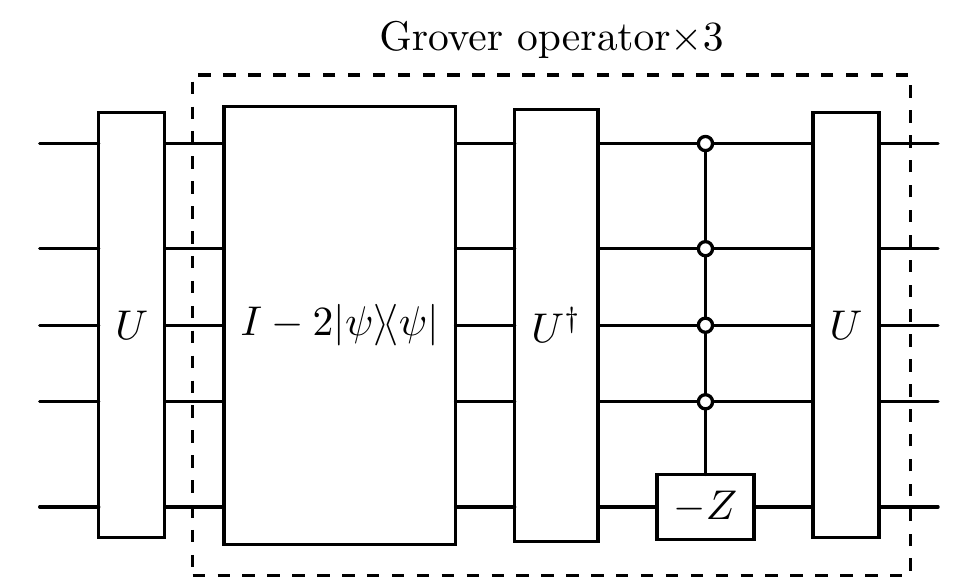

In [6]:
l = 3  

cir = Circuit(num_qubits)
cir.oracle(oracle=U, system_idx=list(range(num_qubits)), latex_name=r'U')

cir.append(Grover(list(range(num_qubits)), l, U, S))

cir.plot(style='compact')

Below we show that the squared absolute value of the inner product between the output state and $\ket{\psi}$ is
$
\sin^2\!\big((2n+1)\theta\big).
$

In [7]:
input_state = zero_state(num_qubits)

sin_theta_complex = psi.bra @ U @ input_state.ket
sin_theta = torch.abs(sin_theta_complex)
theta = torch.asin(torch.clamp(sin_theta, -1, 1))

In [8]:
output_state = cir(input_state)

actual_amplitude = psi.bra @ output_state.ket
actual_probability = torch.abs(actual_amplitude) ** 2

theoretical_amplitude = torch.sin((2*l + 1) * theta).abs()
theoretical_probability = theoretical_amplitude ** 2

difference = torch.abs(actual_probability - theoretical_probability)

print(f"Number of iterations n: {l}")
print(f"Initial angle θ: {theta.item():.4f}")
print(f"Initial amplitude sin(θ): {sin_theta.item():.4f}")
print(f"Theoretical probability sin²((2n+1)θ): {theoretical_probability.item():.6f}")
print(f"Actual probability |<ψ|output>|²: {actual_probability.item():.6f}")
print(f"Absolute difference: {difference.item():.2e}")

Number of iterations n: 3
Initial angle θ: 0.1870
Initial amplitude sin(θ): 0.1859
Theoretical probability sin²((2n+1)θ): 0.932946
Actual probability |<ψ|output>|²: 0.932946
Absolute difference: 1.67e-15


## Unstructured search problem

Unstructured search concerns finding an element that satisfies a Boolean predicate in a list with no ordering or structure, serving as a benchmark to compare classical and quantum query complexities.  

Classically: given $\{0,\dots,N-1\}$ and an oracle $f:\{0,\dots,N-1\}\to\{0,1\}$ with marked set $M=\{x:f(x)=1\}$ of size $m$, the task is to find an $x\in M$. Any randomized classical algorithm requires $\Theta(N/m)$ queries in expectation[3].

The quantum unstructured search problem is defined as follows: given $n$ qubits representing a state space $\{|0\rangle, |1\rangle, \ldots, |N-1\rangle\}$ where $N = 2^n$, and access to a quantum oracle $O_f = I - 2\sum_{x \in M}|x\rangle\langle x|$ that flips the phase of marked states, where $M = \{x : f(x) = 1\}$ is the set of $m$ marked items, the task is to find an element $x \in M$.

The quantum approach prepares the uniform superposition $|\varphi\rangle = H^{\otimes n}|0\rangle = \frac{1}{\sqrt{N}}\sum_{x=0}^{N-1}|x\rangle$ and defines the good state $|\psi\rangle = \frac{1}{\sqrt{m}}\sum_{x\in M}|x\rangle$. The initial amplitude is $\sin\theta = \sqrt{m/N}$, where $\theta$ characterizes the overlap between the uniform state and the good subspace.

In [9]:
N = 2**num_qubits
m = 3  

marked_items = np.random.choice(N, m, replace=False)
print(f"\nSearch space size N = {N}")
print(f"Number of marked elements m = {m}")
print(f"Marked element indices: {np.sort(marked_items)}")


Search space size N = 32
Number of marked elements m = 3
Marked element indices: [ 4 19 29]



As an example, we generate a random function $f$ and provide the corresponding oracle $O_f$, $\ket{\psi}$, and $S$.

In [10]:
f: Callable[[int], int] = lambda x: 1 if x in marked_items else 0

psi = torch.zeros(N)
for i in marked_items:
    psi[i] = 1
psi = to_state(psi / torch.norm(psi))

S = Of(f, num_qubits)

print(f"\nTheoretical parameters:")
print(f"sin(θ) = √(m/N) = {np.sqrt(m/N):.4f}")
theta_grover = np.arcsin(np.sqrt(m/N))
print(f"θ = {theta_grover:.4f}")


Theoretical parameters:
sin(θ) = √(m/N) = 0.3062
θ = 0.3112


Grover's algorithm applies amplitude amplification to the unstructured search problem. Starting from the uniform state $|\varphi\rangle = H^{\otimes n}|0\rangle$, the Grover operator $Q$ rotates the state vector in the two-dimensional subspace spanned by $\{|\psi\rangle,|\psi^\perp\rangle\}$, systematically increasing the good amplitude.

If the initial "good" state amplitude is $\sin\theta$, then after $k$ iterations of standard amplitude amplification (the repeated application of the Grover operator $Q = -DS$), the "good" state amplitude becomes $\sin\big((2k+1)\theta\big)$, and the success probability is $\sin^2\big((2k+1)\theta\big)$.

To maximize the success probability, choose $k$ such that $(2k+1)\theta \approx \frac{\pi}{2}$, which gives $k \approx \frac{\pi}{4\theta} - \frac{1}{2}$. In practice, take $k = \left\lfloor \frac{\pi}{4\theta} - \frac{1}{2} \right\rfloor$.

For the single-solution case ($m=1$), we have $\sin\theta = \sqrt{m/N} = 1/\sqrt{N}$. For large $N$, this gives $\theta \approx \sin\theta = 1/\sqrt{N}$. Applying the optimization formula:
$$
k \approx \frac{\pi}{4\theta} - \frac{1}{2} \approx \frac{\pi}{4 \cdot (1/\sqrt{N})} - \frac{1}{2} = \frac{\pi\sqrt{N}}{4} - \frac{1}{2}  
\tag{7}$$

Therefore, Grover's algorithm finds a solution with high probability using $O(\sqrt{N})$ queries to $O_f$, compared with the classical lower bound of $\Theta(N)$ queries, demonstrating a quadratic quantum speedup.

The following code computes the theoretical optimal number of Grover iterations:

In [11]:
optimal_iterations = int(np.floor(np.pi / (4 * theta_grover) - 0.5))
print(f"\nTheoretical optimal number of iterations: {optimal_iterations}")


Theoretical optimal number of iterations: 2


The following code constructs and executes the Grover quantum circuit with the optimal iteration count, then analyzes the measurement probabilities to verify the theoretical predictions

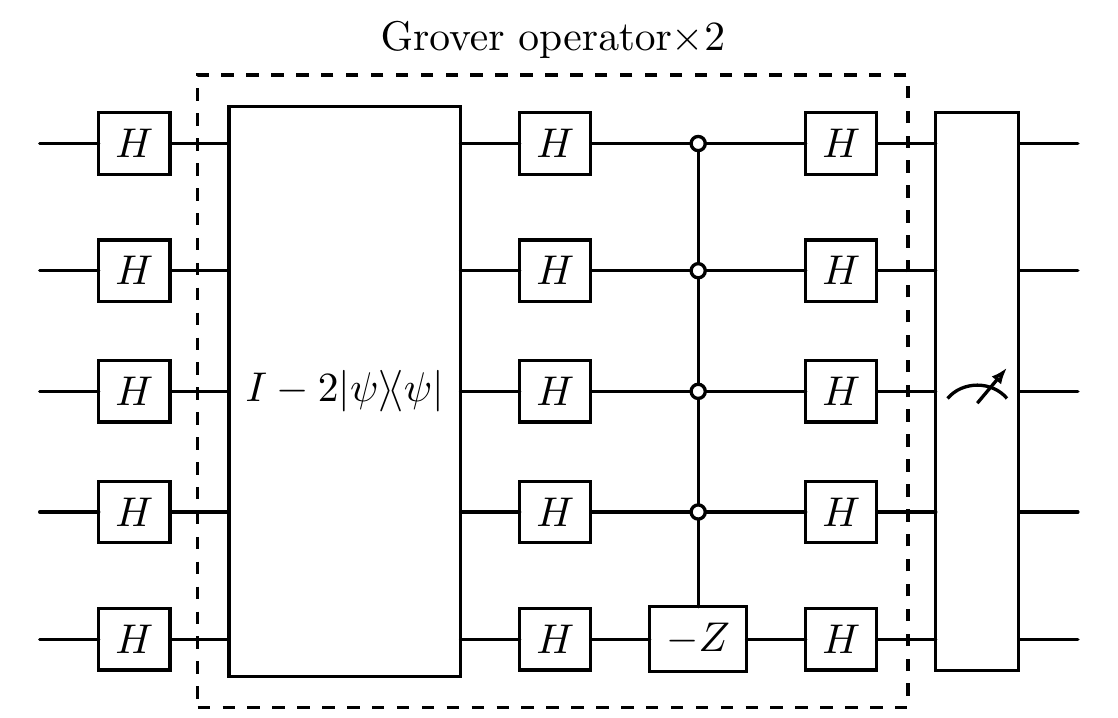

In [12]:
cir = Circuit(num_qubits)
cir.h()
cir.append(Grover(list(range(num_qubits)), optimal_iterations, None, S))
cir.measure()

cir.plot(style='compact')

In [13]:
prob = cir().probability

print(f"\nMeasurement probabilities for each basis state (showing only states with probability > 0.01):")
for i in range(N):
    if prob[i] > 0.01:
        is_marked = "✓ (marked state)" if i in marked_items else ""
        binary_str = format(i, f'0{num_qubits}b')
        print(f"  |{i:2d}⟩ = |{binary_str}⟩: {prob[i].item():.4f} {is_marked}")

total_success_prob = sum(prob[x] for x in marked_items)
print(f"\nTotal success probability: {total_success_prob.item():.6f}")
print(f"Theoretical optimal probability: {np.sin((2*optimal_iterations + 1) * theta_grover)**2:.6f}")


Measurement probabilities for each basis state (showing only states with probability > 0.01):
  | 4⟩ = |00100⟩: 0.3333 ✓ (marked state)
  |19⟩ = |10011⟩: 0.3333 ✓ (marked state)
  |29⟩ = |11101⟩: 0.3333 ✓ (marked state)

Total success probability: 0.999779
Theoretical optimal probability: 0.999779


## Oblivious amplitude amplification

The QAA algorithm[1], while powerful, suffers from a fundamental limitation: it requires access to an oracle $S$ that selectively inverts the phase of marked states. However, implementing $S$ typically necessitates prior knowledge of the target state $\ket{\psi}$, creating a circular dependency. This requirement undermines the practical quantum advantage of algorithms like Grover's search, as one cannot employ QAA without already knowing $\ket{\psi}$.

To fix this problem, we turn to study a variant of the amplitude amplification problem. The problem statement is as follows: consider a unitary $U$ acting on $\mu$ ancilla qubits and $n$ system qubits, satisfying

$$
U | 0^\mu \rangle | \psi \rangle = \sin(\theta) | 0^\mu \rangle V | \psi \rangle + \cos(\theta) | \Phi^\perp \rangle
\tag{8}$$

where $V$ is an unknown unitary and $| \Phi^\perp \rangle$ is an $(\mu+n)$-qubit state with $\Pi| \Phi^\perp \rangle = 0$ for $\Pi = \ket{0^\mu}\bra{0^\mu} \otimes \mathbb{I}$. The goal is to amplify the amplitude of the state $V|\psi\rangle$.

The solution of this problem is known as oblivious amplitude amplification[2]. The key insight is that we can amplify desired amplitudes by only querying a unitary $U$ and its inverse $U^\dagger$, without needing direct access to the target operation $V$ or knowledge of the input state $| \psi \rangle$. This makes the amplification process "oblivious" to the specific input state, requiring only reflections in the ancilla space rather than reflections about unknown quantum states.

One common example for such unitary $U$ is for the technique of linear combination of unitaries (LCU) [4], where $U$ is constructed as a controlled operation over a set of unitaries $\{U_j\}_j$ with control states in the ancilla register.

In [14]:
num_ancilla_qubit = 3
num_main_qubit = 5

U = random_lcu(num_main_qubit, num_ancilla_qubit)

In the code, we simplify the main register by treating it as a large qudit system.

In [15]:
dim_main = 2 ** num_main_qubit
system_dim = [2] * num_ancilla_qubit + [dim_main]

psi = random_state(1, rank=1, system_dim=dim_main)

Initial state amplitude can be computed as $|\sin(\theta)| = || \Pi (U | 0^\mu \rangle | \psi \rangle) ||$.

In [16]:
zero = zero_state(num_ancilla_qubit)
input_state = nkron(zero, psi)
projector = nkron(zero.density_matrix, torch.eye(dim_main))

initial_amplitude = torch.norm(projector @ U @ input_state.ket)
theta = torch.asin(initial_amplitude)

## Implementation of Oblivious Amplitude Amplification

Define the following two operators:
- $R = 2\Pi - \mathbb{I}$: reflection about the subspace with ancilla in $|0^\mu\rangle$
- $Q = -URU^\dagger R$: the amplification operator

The operator $Q$ acts as a generalized rotation in a two-dimensional subspace, analogous to standard amplitude amplification but without requiring reflection about the unknown input state.

**Theorem.** For any integer $l$ and any $n$-qudit state $|\psi\rangle$:
$$
Q^l U|0^\mu\rangle|\psi\rangle = \sin((2l+1)\theta)|0^\mu\rangle V|\psi\rangle + \cos((2l+1)\theta)|\Phi^\perp\rangle  
\tag{9}$$

**Proof.** We proceed by establishing that the evolution remains within a two-dimensional subspace.

Define the states:
- $|\psi_g\rangle = |0^\mu\rangle V|\psi\rangle$ 
- $|\psi_b\rangle = |\Phi^\perp\rangle$ 

These states form an orthonormal basis for the relevant subspace, since $\Pi|\psi_b\rangle = 0$ implies $\langle \psi_g|\psi_b\rangle = 0$, and both states are normalized (the normalization of $|\psi_b\rangle$ follows from the unitarity of $U$).

The initial state after applying $U$ can be written as:
$$U|0^\mu\rangle|\psi\rangle = \sin(\theta)|\psi_g\rangle + \cos(\theta)|\psi_b\rangle  
\tag{10}$$

The reflection $R$ acts as:
- $R|\psi_g\rangle = |\psi_g\rangle$ (since $\Pi|\psi_g\rangle = |\psi_g\rangle$)
- $R|\psi_b\rangle = -|\psi_b\rangle$ (since $\Pi|\psi_b\rangle = 0$)

To compute the action of $Q = -URU^\dagger R$ in the subspace spanned by $\{|\psi_g\rangle, |\psi_b\rangle\}$, we introduce auxiliary states:
- $|\alpha\rangle = \sin(\theta)|\psi_g\rangle + \cos(\theta)|\psi_b\rangle = U|0^\mu\rangle|\psi\rangle$ 
- $|\beta\rangle = \cos(\theta)|\psi_g\rangle - \sin(\theta)|\psi_b\rangle$ (orthogonal to $|\alpha\rangle$)

The operator $URU^\dagger$ reflects about $|\alpha\rangle$:
- $URU^\dagger|\alpha\rangle = |\alpha\rangle$
- $URU^\dagger|\beta\rangle = -|\beta\rangle$

Expressing the basis states in terms of $\{|\alpha\rangle, |\beta\rangle\}$:
- $|\psi_g\rangle = \sin(\theta)|\alpha\rangle + \cos(\theta)|\beta\rangle$
- $|\psi_b\rangle = \cos(\theta)|\alpha\rangle - \sin(\theta)|\beta\rangle$

Computing $Q|\psi_g\rangle$:
$$
\begin{aligned}
URU^\dagger|\psi_g\rangle & = \sin(\theta)|\alpha\rangle - \cos(\theta)|\beta\rangle = -\cos(2\theta)|\psi_g\rangle + \sin(2\theta)|\psi_b\rangle \\
Q|\psi_g\rangle           & = -URU^\dagger R|\psi_g\rangle = \cos(2\theta)|\psi_g\rangle - \sin(2\theta)|\psi_b\rangle
\end{aligned}
$$

Computing $Q|\psi_b\rangle$:
$$
\begin{aligned}
URU^\dagger|\psi_b\rangle & = \cos(\theta)|\alpha\rangle + \sin(\theta)|\beta\rangle = \sin(2\theta)|\psi_g\rangle + \cos(2\theta)|\psi_b\rangle \\
Q|\psi_b\rangle           & = -URU^\dagger R|\psi_b\rangle = URU^\dagger|\psi_b\rangle = \sin(2\theta)|\psi_g\rangle + \cos(2\theta)|\psi_b\rangle
\end{aligned}
$$

In the basis $\mathbb{B} = \{|\psi_g\rangle, |\psi_b\rangle\}$:
$$Q = \begin{pmatrix} \cos(2\theta) & \sin(2\theta) \\ -\sin(2\theta) & \cos(2\theta) \end{pmatrix}_\mathbb{B}  
$$

This is a rotation matrix by angle $-2\theta$. Therefore:
$$Q^l = \begin{pmatrix} \cos(2l\theta) & \sin(2l\theta) \\ -\sin(2l\theta) & \cos(2l\theta) \end{pmatrix}_\mathbb{B}  
$$

Applying $Q^l$ to the initial state:

$$\begin{aligned}
Q^l U|0^\mu\rangle|\psi\rangle &= Q^l(\sin(\theta)|\psi_g\rangle + \cos(\theta)|\psi_b\rangle) \\
&= \begin{pmatrix} \cos(2l\theta) & \sin(2l\theta) \\ -\sin(2l\theta) & \cos(2l\theta) \end{pmatrix}_\mathbb{B} \begin{pmatrix} \sin(\theta) \\ \cos(\theta) \end{pmatrix}_\mathbb{B} \\
&= \begin{pmatrix} \sin((2l+1)\theta) \\ \cos((2l+1)\theta) \end{pmatrix}_\mathbb{B} \\
&= \sin((2l+1)\theta)|\psi_g\rangle + \cos((2l+1)\theta)|\psi_b\rangle \\
&= \sin((2l+1)\theta)|0^\mu\rangle V|\psi\rangle + \cos((2l+1)\theta)|\Phi^\perp\rangle
\end{aligned}$$

<figure style="text-align: center;">
  <img src="figures/qaa_grover.png" alt="alt text"/>
  <figcaption>The Q operator performs a 2θ rotation, amplifying the good component. </figcaption>
</figure>

This completes the proof. The amplification proceeds without knowledge of $|\psi\rangle$, requiring only the ability to implement $U$ and the reflection $R$ about the ancilla subspace. The following is the OAA layer implements the amplification operator $Q$ up to a global phase.

In [17]:
class OAA(Layer):
    r"""Circuit layer for oblivious amplitude amplification operator
    
    Args:
        system_idx: Indices of the systems in the circuit.
        num: The number of OAA iterations to perform.
        U_op: The state preparation unitary operator.
        dims: List of dimensions for each subsystem [ancilla_dim, main_dim].
    """
    def __init__(self, system_idx: List[int], num: int, oracle: torch.Tensor) -> None:
        super().__init__(system_idx, num, 'Amplification operator', system_dim=system_dim)
        
        self.oracle = oracle
        
        for _ in range(num):
            self.__add_layer()
        
    def __add_layer(self) -> None:
        system_idx = self.system_idx
        ancilla_dim = system_dim[:-1]
        
        control_idx, apply_idx = list(range(num_ancilla_qubit - 1)), num_ancilla_qubit - 1
        self.append(ControlOracle(-z(), [control_idx, apply_idx], index=0, 
                                  acted_system_dim=ancilla_dim, gate_info={"tex": r'-Z'}))
        
        self.append(Oracle(dagger(self.oracle), system_idx, acted_system_dim=system_dim, 
                          gate_info={"tex": r'U^\dagger'}))
        
        self.append(ControlOracle(-z(), [control_idx, apply_idx], index=0, 
                                  acted_system_dim=ancilla_dim, gate_info={"tex": r'-Z'}))
        
        self.append(Oracle(self.oracle, system_idx, acted_system_dim=system_dim, 
                          gate_info={"tex": r'U'}))


As an experiment, we can show that OAA would do the same thing as the conventional one. For simplicity, consider a iteration number $l = \lfloor \frac{3\pi}{4\theta} - \frac{1}{2} \rfloor$ such that $|\sin((2l + 1)\theta)| \to 1$.

In [18]:
l = int(torch.floor(3 * torch.pi / (4 * theta) - 0.5))
theoretical_amplitude = torch.abs(torch.sin((2*l + 1) * theta))

The overall circuit is constructed as follows:

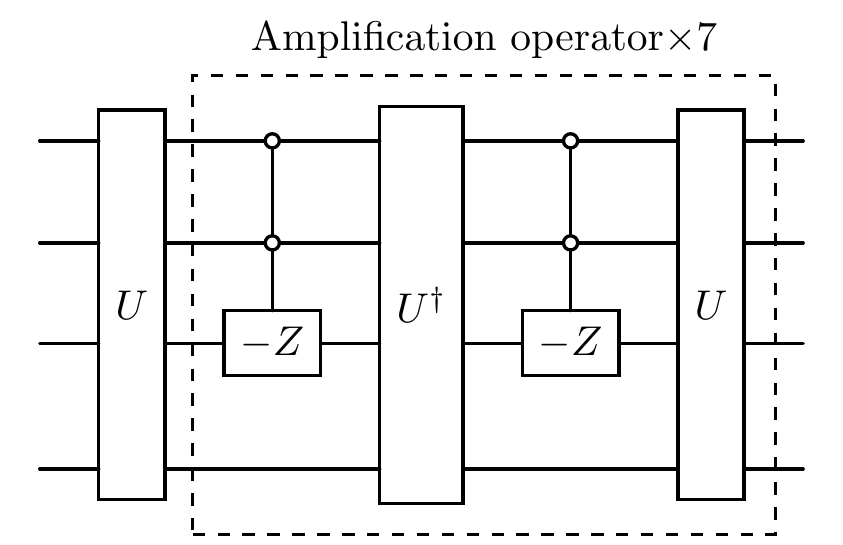

In [19]:
cir = Circuit(num_systems=num_ancilla_qubit + 1, system_dim=system_dim)

cir.oracle(U, system_idx=list(range(num_ancilla_qubit + 1)), latex_name=r'U')
cir.append(OAA(list(range(num_ancilla_qubit + 1)), l, U))

cir.plot('compact')

As shown below, the circuit enhances the amplitude from $|\sin(\theta)|$ to $|\sin((2l+1)\theta)|$. By choosing $l$ such that $(2l+1)\theta \approx \pi/2$, we can implement $V$ with near-certainty without ever needing to know the specific form of $\ket{\psi}$.

This construction is particularly useful when $U$ can be efficiently implemented but $V$ itself is difficult to realize directly. The amplification process effectively "extracts" the $V$ operation from $U$ through repeated applications of $Q = -URU^\dagger R$.

In [20]:
output_state = cir(input_state)
actual_amplitude = torch.norm(projector @ output_state.ket)
difference = torch.abs(actual_amplitude - theoretical_amplitude)

print(f"Expect amplitude = {theoretical_amplitude.item():.6f}")
print(f"Actual amplitude = {actual_amplitude.item():.6f}")
print(f"Absolute difference: {difference.item():.2e}")

Expect amplitude = 0.999634
Actual amplitude = 0.999634
Absolute difference: 6.66e-16


## Extension

### Quantum Singular Value Transformation Framework

Oblivious amplitude amplification is a special case of the more general quantum singular value transformation (QSVT)[5] framework. QSVT provides a systematic method for implementing polynomial transformations on the singular values of a block-encoded matrix. In the context of OAA, the unitary $U$ block-encodes the operator $V$ with singular value $\sin(\theta)$. The amplification process corresponds to applying a polynomial transformation to this singular value.

Specifically, QSVT operates on the two-dimensional subspace spanned by $\{\ket{0}V\ket{\psi}, \ket{\Phi^\perp}\}$ and implements polynomial functions of the block-encoding parameter. The OAA operator $S^l U$ realizes the Chebyshev polynomial of the first kind: $f(\sin(\theta)) = \sin((2l+1)\theta)$, which corresponds to the linear transformation $f(x) = T_{2l+1}(x)$ where $T_n$ is the $n$-th Chebyshev polynomial. This perspective reveals that OAA performs a specific polynomial transformation that amplifies the desired component while preserving unitarity.

### Eliminating the Requirement for $U^\dagger$

While the standard formulation of OAA requires both $U$ and $U^\dagger$, the inverse operation can be eliminated since for any $d$-dimensional unitary $U$, the inverse $U^\dagger$ can be implemented using $O(d^2)$ controlled applications of $U$[6].

The construction works by decomposing $U^\dagger$ as a linear combination of powers of $U$: since $U$ is unitary with eigenvalues on the unit circle, we can write $U^\dagger = \sum_{k=0}^{d-1} c_k U^k$ for appropriate coefficients $c_k$. Using the Linear Combination of Unitaries (LCU) technique, this decomposition can be implemented with $O(d^2)$ queries to controlled-$U$ operations. Therefore, OAA requires only the ability to implement $U$, making it truly "oblivious" in the sense that neither $V$ nor $U^\dagger$ needs to be explicitly known or implemented.

---

## References

[1] Brassard, Gilles, et al. "Quantum amplitude amplification and estimation." arXiv preprint quant-ph/0005055 (2000).

[2] Berry, Dominic W., et al. "Exponential improvement in precision for simulating sparse Hamiltonians." Proceedings of the forty-sixth annual ACM symposium on Theory of computing. 2014.

[3] Santha, Miklos. "Quantum walk based search algorithms." International Conference on Theory and Applications of Models of Computation. Berlin, Heidelberg: Springer Berlin Heidelberg, 2008.

[4] Childs, Andrew M., and Nathan Wiebe. "Hamiltonian simulation using linear combinations of unitary operations." arXiv preprint arXiv:1202.5822 (2012).

[5] Gilyén, András, et al. "Quantum singular value transformation and beyond: exponential improvements for quantum matrix arithmetics." Proceedings of the 51st annual ACM SIGACT symposium on theory of computing. 2019.

[6] Chen, Yu-Ao, et al. "Quantum Algorithm for Reversing Unknown Unitary Evolutions." arXiv preprint arXiv:2403.04704 (2024).


*Table: A reference of notation conventions in this tutorial.*

| Symbol | Variant | Description |
|:------:|:-------:|-------------|
| $\ket{\psi}$ | $\ket{\psi_{\text{good}}}$ | Target/good state to be amplified |
| $\ket{\psi^{\perp}}$ | $\ket{\psi_{\text{bad}}}$ | Orthogonal complement to good state |
| $U$ | $\mathcal{A}$ | State preparation unitary/oracle |
| $S$ | $O_f$, $S_{\psi}$ | Phase oracle/reflection operator |
| $Q$ |  | Grover/amplification operator |
| $\theta$ | | Initial amplitude angle |
| $\mathbb{B}$ | | Basis of 2-dimensional rotation subspace |
| $\Pi$ | | Projector onto ancilla subspace |
| $R$ | | Reflection operator |
| $m$ |  | Number of marked items |
| $N$ | | Size of search space |

In [21]:
qkit.print_info()


---------VERSION---------
quairkit: 0.4.4
torch: 2.8.0+cpu
numpy: 2.2.6
scipy: 1.15.3
matplotlib: 3.10.6
---------SYSTEM---------
Python version: 3.10.18
OS: Windows
OS version: 10.0.26100
---------DEVICE---------
CPU: ARMv8 (64-bit) Family 8 Model 1 Revision 201, Qualcomm Technologies Inc
